In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from flask import Flask, render_template
from sklearn.datasets import make_blobs 
from mpl_toolkits.mplot3d import Axes3D
import random
from itertools import groupby
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import seaborn as sns
import itertools
from functools import reduce
from itertools import product
from itertools import combinations








In [107]:
def redimensionner(A,b,precision=2):
    for i in range(len(b)):
        x = b[i][0]/A[i][i]
        if A[i][i] > (10**(precision+1)) and x > 1/10**precision :# Very important precision+1 to avoid stagnation 
            div = math.ceil(x * 10**precision) / 10**precision
            b[i][0] = div*10**precision
            A[i][i] = 10**precision
    return A ,b

def redimensionner_v2(A,b,theta,precision):
    """
    Voici l'explication ici theta doit rester inchange car c'est elle qui est utilisé dans la formule finale pour le calcul de l'ucb.
    On veut modifier A et b on diminuant leur valeur de tel sorte que theta reste inchange.

    Soit theta fixe.

    On fixe le nouveau A nomé A' dont on a diminué les valeurs . Ensuite on cherche le nouveau b' tel (A')^-1 * b' = theta

    Donc b' = A'*theta

    et on a  bien (A')^-1 * b' = (A')^-1 * A' * theta = theta , aussi simple que ca.

    A noter qu'on diminuant la valeur de A, on diminue automatiquement la valeur b. 

    Car par exemple avant on a a11*theta1 + a22*theta2 = b1

    or mnt  a'11 < a11 et  a'22 < a22 , et donc     a'11*theta1 + a'22*theta2 = b'1   <  a11*theta1 + a22*theta2 = b1
        
    """
    base = 10**precision
    condition = 10**(precision+1) # Very important precision+1 to avoid stagnation
    for i in range(len(theta)) :
        if (abs(theta[i][0])> 1 /base): #and theta[i][0] > 0): 
            #A[A>condition] = base
            A[i][A[i]>condition] = A[i][A[i]>condition]/10
            #A[i][A[i]>condition] = base
    b = np.dot(A,theta)
    return A , b

def normalize_matrix(A):
    # Calcule la norme de Frobenius de la matrice A
    norm = np.linalg.norm(A, 'fro')
    
    # Détermine la constante de normalisation optimale
    k = norm / np.sqrt(np.size(A))
    
    # Normalise la matrice en divisant par la constante k
    normalized_A = A / norm
    
    return normalized_A


class linucb_disjoint_arm():

        # each arm can have his own set of parameters (xi), this why we call it disjoint
    def __init__(self, arm_index, d, alpha,version):

        #Version of algorihtm
        self.version = version

        # Track arm index
        self.arm_index = arm_index
        
        # Keep track of alpha
        self.alpha = alpha
        
        # A: (d x d) matrix = D_a.T * D_a + I_d. 
        # The inverse of A is used in ridge regression 
        self.A_incertitude = np.identity(d)
        self.A_theta = np.identity(d)
        
        # b: (d x 1) corresponding response vector. 
        # Equals to D_a.T * c_a in ridge regression formulation
        self.b = np.zeros([d,1])

        self.A_theta_list = []
        self.A_incertitude_list = []
        self.b_list = []
        self.theta_list = []
        self.ucb_evo = []
        self.alpha_list = []
                
    def calc_UCB(self, x_array):
        # Find A inverse for ridge regression
            
        self.A_inv_incertitude = np.linalg.inv((self.A_incertitude.copy())) #<-----
        self.A_inv_theta = np.linalg.inv(self.A_theta)

        # Perform ridge regression to obtain estimate of covariate coefficients theta
        # theta is (d x 1) dimension vector
        
        self.theta = np.dot(self.A_inv_theta, self.b) # each point of covariate estime une importance globale qu'accorde une arm à chaque feature
        #if self.version ==2 :
            #self.theta = self.theta / (sum(abs(self.theta))+0.0001) # <--------- AJOUT 
        # b est le poids qu'on pondère grace à la variance de x 

        # comme ca quand on a un datapoint on fait une regression avec ce teta (plus une deviation), ce nombre obtenu est l'importance
        # que peut donner un utilistauer 
        
        # Reshape covariates input into (d x 1) shape vector
        x = x_array.reshape([-1,1])
        
        
        # Find ucb based on p formulation (mean + std_dev) 
        # p is (1 x 1) dimension vector

        p = np.dot(self.theta.T,x) +   self.alpha * np.sqrt(np.dot(x.T, np.dot(self.A_inv_incertitude,x))) # !!TESTER AVEC DEUX X DIFFERENTS CE QUE CA DONNE!!
        
        # la récompense la plus haute espéré pour ce bras
        # et on rajouter la std pour l'exploration des arm qui ont une grande incertitude dans la variance de leur features 
        self.A_theta_list.append(self.A_theta.copy())
        self.A_incertitude_list.append(self.A_incertitude.copy())
        self.b_list.append(self.b.copy())
        self.theta_list.append(self.theta.copy())
        self.alpha_list.append(self.alpha)
        # -----------------
        return p
    
    
    def calc_UCB_test(self, x_array):
        #self.A_inv_incertitude = np.linalg.inv(self.A_incertitude)
        self.A_inv_incertitude = np.linalg.inv((self.A_incertitude.copy()))
        self.A_inv_theta = np.linalg.inv(self.A_theta)
        #if self.version ==2 :
            #self.theta = self.theta / (sum(abs(self.theta))+0.0001)  # <--------- AJOUT
        self.theta = np.dot(self.A_inv_theta, self.b) 
        x = x_array.reshape([-1,1])
        return np.dot(self.theta.T,x) ,   self.alpha * np.sqrt(np.dot(x.T, np.dot(self.A_inv_incertitude,x)))
    
    def reward_update(self, reward, x_array):
        # Reshape covariates input into (d x 1) shape vector        
        x = x_array.reshape([-1,1])
        
        # Update A which is (d * d) matrix.

        self.A_incertitude += np.dot(x, x.T)
        self.A_theta += np.dot(x, x.T)
        

        # Update b which is (d x 1) vector
        # reward is scalar
        self.b += reward * x # les features qui accordent une récompense positive et qui ont le plus d'importance pour l'arm vont etre sommé  // que -0.1 et 1 
        # Redimensionnement
        if self.version == 1 :
            self.A_theta,self.b = redimensionner(self.A_theta,self.b)

        if self.version == 2 :
            self.A_inv_theta = np.linalg.inv(self.A_theta)
            self.theta = np.dot(self.A_inv_theta, self.b)
            #self.theta = self.theta / (sum(abs(self.theta))+0.0001)  # <--------- AJOUT
            self.A_theta,self.b = redimensionner_v2(self.A_theta.copy(),self.b,self.theta,2)
        

In [66]:
class linucb_policy():
    
    def __init__(self, K_arms, d, alpha,version):
        self.K_arms = K_arms
        self.version = version
        self.linucb_arms = [linucb_disjoint_arm(arm_index = i, d = d, alpha = alpha,version = version) for i in range(K_arms)]
    
        
    def select_arm(self, x_array):
        # Initiate ucb to be 0
        highest_ucb = -1
        
        # Track index of arms to be selected on if they have the max UCB.
        candidate_arms = []
        for arm_index in range(self.K_arms):
            # Calculate ucb based on each arm using current covariates at time t
            arm_ucb = self.linucb_arms[arm_index].calc_UCB(x_array)

            # For track 
            tuple_ucb_theta_i = self.linucb_arms[arm_index].calc_UCB_test(x_array)

            #indice = np.where(x_array == 1)[0][0]  
            indice = np.where((df_encoded.iloc[:, :df_encoded.shape[1]-1] == x_array).all(axis=1))[0][0] ##### @@@@@@ @@@@@@ @@@@@@ @@@@@@  
            indice = df_encoded.iloc[indice][-1] ##### @@@@@@ @@@@@@ @@@@@@ @@@@@@ @@@@@@ @@@@@@ 
            
            self.linucb_arms[arm_index].ucb_evo.append((indice,arm_ucb[0][0],tuple_ucb_theta_i[0][0][0],tuple_ucb_theta_i[1][0][0]))

            # If current arm is highest than current highest_ucb
            if arm_ucb > highest_ucb:
                
                # Set new max ucb
                highest_ucb = arm_ucb
                
                # Reset candidate_arms list with new entry based on current arm
                candidate_arms = [(arm_index,arm_ucb)]

            # If there is a tie, append to candidate_arms
            elif arm_ucb == highest_ucb:
                candidate_arms.append((arm_index,arm_ucb))
        # Choose based on candidate_arms randomly (tie breaker)
        if candidate_arms==[]:
            print('PBBB')
            print(highest_ucb)
            print(candidate_arms)
        chosen_arm = [t[0] for t in candidate_arms]
        chosen_arm = np.random.choice(chosen_arm)
        
        return chosen_arm

In [31]:
def ctr_simulator(K_arms, d, alpha, data_path):
    # Initiate policy
    linucb_policy_object = linucb_policy(K_arms = K_arms, d = d, alpha = alpha) # intialise les coefficienet A et b de chaque arme

    # Instantiate trackers
    aligned_time_steps = 0
    cumulative_rewards = 0
    aligned_ctr = []
    unaligned_ctr = [] # for unaligned time steps
    
    # Open data
    with open(data_path, "r") as f:

        for line_data in f:

            # 1st column: Logged data arm. 
            # Integer data type
            data_arm = int(line_data.split()[0])

            # 2nd column: Logged data reward for logged chosen arm
            # Float data type
            data_reward = float(line_data.split()[1])

            # 3rd columns onwards: 100 covariates. Keep in array of dimensions (100,) with float data type
            covariate_string_list = line_data.split()[2:]
            data_x_array = np.array([float(covariate_elem) for covariate_elem in covariate_string_list])

            # Find policy's chosen arm based on input covariates at current time step
            arm_index = linucb_policy_object.select_arm(data_x_array)

            # Check if arm_index is the same as data_arm (ie same actions were chosen)
            # Note that data_arms index range from 1 to 10 while policy arms index range from 0 to 9.
            if arm_index + 1 == data_arm:

                # Use reward information for the chosen arm to update
                linucb_policy_object.linucb_arms[arm_index].reward_update(data_reward, data_x_array)

                # For CTR calculation
                aligned_time_steps += 1
                cumulative_rewards += data_reward
                aligned_ctr.append(cumulative_rewards/aligned_time_steps)
                    
    return (aligned_time_steps, cumulative_rewards, aligned_ctr, linucb_policy_object)

In [32]:
def simulate_reward(cluster_id,arm_id):
    penality = 0
    if cluster_id==arm_id: # in this case we choosed the good arm but doesn't mean for sure postive reward but high proba
        p = 0.6
        return random.choices([penality,1], [1-p,p])[0]
    else :
        p = 0.1
        return random.choices([penality,1], [1-p,p])[0]
    

In [33]:
df_encoded['cluster'].value_counts()

cluster
0    1125
4    1125
5    1125
2    1125
3    1125
1    1125
Name: count, dtype: int64

In [34]:
for i in range(6):
    print(i," -> ",5-i)

0  ->  5
1  ->  4
2  ->  3
3  ->  2
4  ->  1
5  ->  0


In [67]:

def simulate_reward_shift(cluster_id,arm_id):
    prefered_arm =  shift(cluster_id)
    penality = 0
    if prefered_arm==arm_id: # in this case we choosed the good arm but doesn't mean for sure postive reward but high proba
        p = 0.6
        return random.choices([penality,1], [1-p,p])[0]
    else :
        p = 0.1
        return random.choices([penality,1], [1-p,p])[0]
    

def shift(c_id):
    return 5 - c_id


In [68]:
def ctr_simulator(df, policy):
    # Instantiate trackers
    aligned_time_steps = 0
    cumulative_rewards = 0
    aligned_ctr = []
    unaligned_ctr = [] # for unaligned time steps
    for i in range(len(df)):
        array = np.array(df.iloc[i])
        data_x_array = np.delete(array,-1) # enlève dernier élement 
        arm_index =  policy.select_arm(data_x_array) #random.randint(0, 2)
        data_reward = simulate_reward(array[-1],arm_index)
        # Use reward information for the chosen arm to update
        policy.linucb_arms[arm_index].reward_update(data_reward, data_x_array)
        # For CTR calculation
        aligned_time_steps += 1
        cumulative_rewards += data_reward
        aligned_ctr.append(cumulative_rewards/aligned_time_steps)
        unaligned_ctr.append(cumulative_rewards)
        if (i%1000==0):
            print(i)


    return (unaligned_ctr,aligned_time_steps, cumulative_rewards, aligned_ctr, policy)


def ctr_simulator_shift(df, policy):
    # Instantiate trackers
    aligned_time_steps = 0
    cumulative_rewards = 0
    aligned_ctr = []
    unaligned_ctr = [] # for unaligned time steps
        
    for i in range(len(df)):
        array = np.array(df.iloc[i])
        data_x_array = np.delete(array,-1) # enlève dernier élement 
        arm_index = policy.select_arm(data_x_array)
        data_reward = simulate_reward_shift(array[-1],arm_index)
        # Use reward information for the chosen arm to update
        policy.linucb_arms[arm_index].reward_update(data_reward, data_x_array)

        # For CTR calculation
        aligned_time_steps += 1
        cumulative_rewards += data_reward
        aligned_ctr.append(cumulative_rewards/aligned_time_steps)
        unaligned_ctr.append(cumulative_rewards)
        if (i%1000==0):
            print(i)
    return (unaligned_ctr,aligned_time_steps, cumulative_rewards, aligned_ctr, policy)


0
1000
2000
3000
4000
5000
6000
0
1000
2000
3000
4000
5000
6000
6750
3982
0.589925925925926


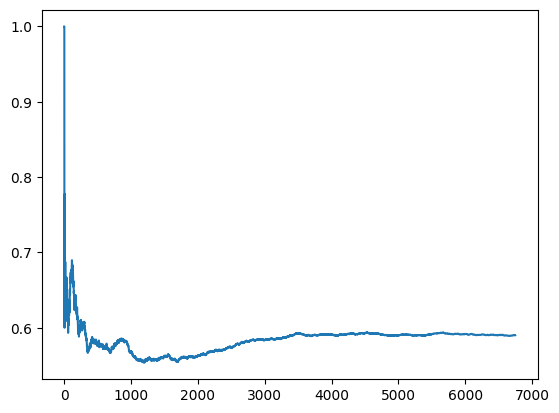

In [133]:
#Initialisation
linucb_policy_object = linucb_policy(K_arms = len(df_encoded['cluster'].value_counts()), d = df_encoded.shape[1]-1, alpha=1,version=-1)

"""unaligned_ctr,aligned_time_steps, cumulative_rewards, aligned_ctr, linucb_policy_object=ctr_simulator(df_encoded,linucb_policy_object)
unaligned_ctr,aligned_time_steps, cumulative_rewards, aligned_ctr, linucb_policy_object=ctr_simulator(df_encoded,linucb_policy_object)


print(aligned_time_steps)
print(cumulative_rewards)
plt.plot(aligned_ctr)
print(aligned_ctr[-1])
plt.show()
"""

unaligned_ctr,aligned_time_steps, cumulative_rewards, aligned_ctr, linucb_policy_object=ctr_simulator_shift(df_encoded,linucb_policy_object)
unaligned_ctr,aligned_time_steps, cumulative_rewards, aligned_ctr, linucb_policy_object=ctr_simulator_shift(df_encoded,linucb_policy_object)

print(aligned_time_steps)
print(cumulative_rewards)
plt.plot(aligned_ctr)
print(aligned_ctr[-1])
plt.show()

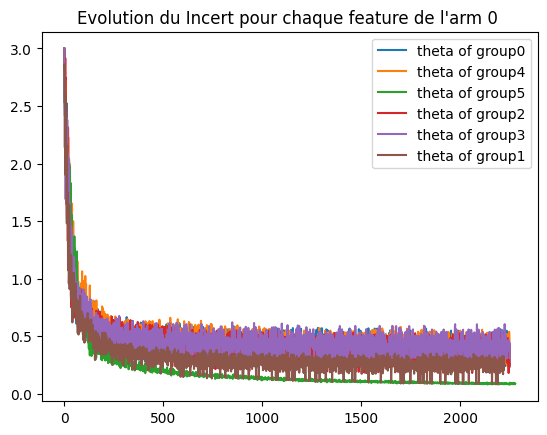

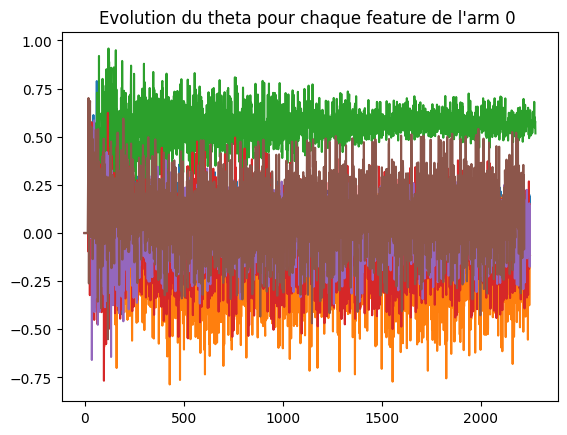

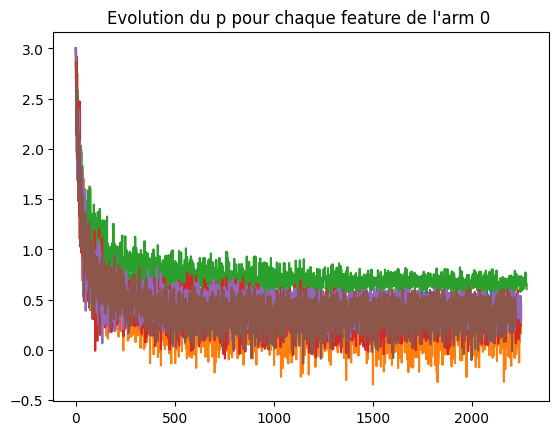

In [134]:
def initiate_ucb_ev_dict(nb_arm ,listt):
    result = {}
    for i in listt :
        result[i]={'p':[],'theta':[],'Incert':[]}
    return result


def evolution_paramètre_arm(arm_id,nb_arm,listt):
    arm_ucb_ev=linucb_policy_object.linucb_arms[arm_id].ucb_evo
    result=initiate_ucb_ev_dict(nb_arm , listt)
    for e in arm_ucb_ev:
        feature = e[0]
        result[feature]['p'].append(e[1])
        result[feature]['theta'].append(e[2])
        result[feature]['Incert'].append(e[3])
    return result

arm = 0
nb_a = 3
fromm = 0
to = -1
listt = list(df_encoded['cluster'].value_counts().index)
result=evolution_paramètre_arm(arm,nb_a,listt)
for i in listt:
    plt.plot(result[i]['Incert'][fromm:to], label='theta of group'+str(i))
plt.title("Evolution du Incert pour chaque feature de l'arm 0 ")
plt.legend()
plt.show()

for i in listt:
    plt.plot(result[i]['theta'][fromm:to], label='theta of group'+str(i))
plt.title("Evolution du theta pour chaque feature de l'arm 0 ")
#plt.legend()
plt.show()

for i in listt:
    plt.plot(result[i]['p'][fromm:to], label='theta of group'+str(i))
plt.title("Evolution du p pour chaque feature de l'arm 0 ")
#plt.legend()
plt.show()

# form de la courbe => racine(1/x)=1/racine(x)
# le alpha doit faire en sorte que incercitude doit etre dans le meme ordre de grandeur que theta



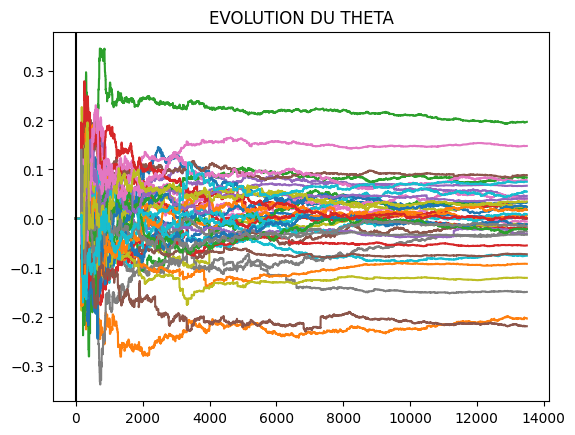

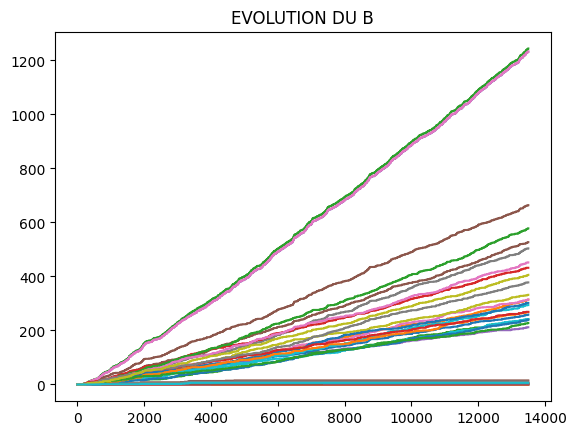

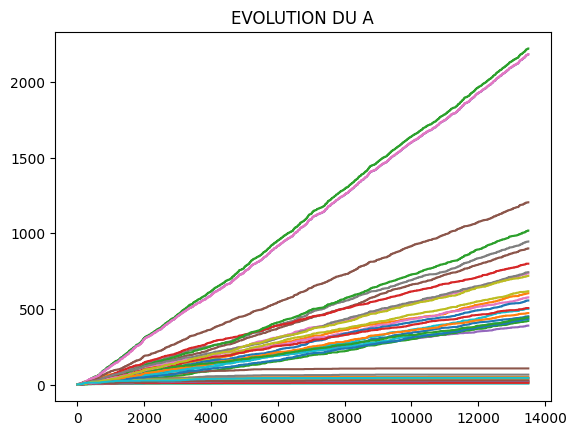

In [135]:
# Créer l'array de données
arm = 0
fromm = 0
to = -1
axe=0
dataT = np.array(linucb_policy_object.linucb_arms[arm].theta_list[fromm:to])
dataB = np.array(linucb_policy_object.linucb_arms[arm].b_list[fromm:to])
dataA = np.array(linucb_policy_object.linucb_arms[arm].A_theta_list[fromm:to])

# Afficher l'évolution de chaque point sur une courbe
for i in range(dataT.shape[1]):
    plt.plot(dataT[:,i,:], label='feature {}'.format(i))

#plt.legend()
plt.axvline(x=axe, color='black')
plt.title("EVOLUTION DU THETA")
plt.show()

# Afficher l'évolution de chaque point sur une courbe
for i in range(dataB.shape[1]):
    plt.plot(dataB[:,i,:], label='feature {}'.format(i))
#----
#plt.legend()
#plt.axvline(x=axe, color='black')
plt.title("EVOLUTION DU B")
plt.show()

# Afficher l'évolution de chaque point sur une courbe
for i in range(dataA.shape[1]):
    plt.plot(dataA[:,i,i], label='feature {}'.format(i))
#----
#plt.legend()
#plt.axvline(x=axe, color='black')
plt.title("EVOLUTION DU A")
plt.show()

#0 4 8 -> 3 7


In [130]:
max(dataT[-1])

array([0.36534012])

In [132]:
sum(dataT[-1])

array([0.33701813])

In [121]:
linucb_policy_object.linucb_arms[0].A_inv_theta

array([[ 0.02265403, -0.00216076,  0.00567051, ...,  0.00341734,
        -0.00390493, -0.00365666],
       [-0.0021634 , -0.00201454, -0.00247483, ...,  0.0023373 ,
        -0.00239146,  0.00151338],
       [ 0.00566447, -0.00249026,  0.00731761, ...,  0.00423724,
        -0.00481486, -0.00012267],
       ...,
       [ 0.00338166,  0.00228954,  0.00417588, ..., -0.00451669,
         0.00453201, -0.0026316 ],
       [-0.0038811 , -0.00235077, -0.00476554, ...,  0.00454845,
        -0.00422357,  0.00255533],
       [-0.00364041,  0.00151718, -0.00011062, ..., -0.00266879,
         0.00258308,  0.00735175]])

In [126]:
linucb_policy_object.linucb_arms[0].A_inv_incertitude

array([[ 0.29312546,  0.27979639,  0.28145488, ..., -0.02370504,
        -0.02374668, -0.02671843],
       [ 0.27979639,  0.29137256,  0.28450084, ..., -0.02460657,
        -0.02462282, -0.02246602],
       [ 0.28145488,  0.28450084,  0.28955942, ..., -0.02412884,
        -0.02405099, -0.02341673],
       ...,
       [-0.02370504, -0.02460657, -0.02412884, ...,  0.15545744,
         0.15517605,  0.15346867],
       [-0.02374668, -0.02462282, -0.02405099, ...,  0.15517605,
         0.15556866,  0.15344441],
       [-0.02671843, -0.02246602, -0.02341673, ...,  0.15346867,
         0.15344441,  0.16064671]])

In [18]:
def choix_compo_features(nb_feature,nb_min_categorie,nb_max_categorie):
    dict_composition_features = dict() # contient le nombre de catégorie pour chaque feature 
    columns = []
    nombre_individu_distinct = 1
    for i in range(nb_feature):
        feature = 'feature'+str(i)
        dict_composition_features[feature] = random.randint(nb_min_categorie, nb_max_categorie)
        columns.append(feature)
        nombre_individu_distinct = nombre_individu_distinct * dict_composition_features[feature]

    return dict_composition_features , nombre_individu_distinct

def genererate_data(nb_feature,nb_min_categorie,nb_max_categorie,nb_individu) :
    ## disctuer avec olivier sur la distribution des des categorie

    dict_composition_features , nombre_individu_distinct = choix_compo_features(nb_feature,nb_min_categorie,nb_max_categorie)

    # Initalisation du data frame 
    columns = ['feature'+str(f) for f in range(len(dict_composition_features))]
    df = pd.DataFrame(columns=columns)
    for i in range(nb_individu):
        nouvelle_ligne = {}
        for j in range(nb_feature):
            feature = 'feature'+str(j)
            nouvelle_ligne[feature] = random.randint(1, dict_composition_features[feature])
        df.loc[len(df)] = nouvelle_ligne
    return df , dict_composition_features , nombre_individu_distinct


In [19]:
def generer_des_groupes(dict_composition_features,nb_groupes):
    groupes = []
    for i in range(nb_groupes):
        groupe_i = []
        for feature in dict_composition_features:
            max = dict_composition_features[feature]
            nb = random.randint(1,max)
            groupe_i.append(random.sample(range(1,max+1), nb))
        groupes.append(groupe_i)
    return groupes

def nb_possibilite(groupes):
    return [reduce((lambda x, y: x * y), list(map((lambda x: len(x) ), g))) for g in groupes]

def distance(x,y):
    set1 = set(x)
    set2 = set(y)
    similarity = len(set1.intersection(set2)) / len(set1.union(set2))
    return 1 - similarity

def distance_groupes(x,y):
    l = [distance(x[i],y[i]) for i in range(len(x)) ]
    return sum(l) / len(l)

def distance_moyenne_entre_paires_groupes(groupes):
    cmpt = 0
    summ = 0
    list_dist = []
    for pair in itertools.combinations(list(range(len(groupes))), 2):
        cmpt = cmpt + 1
        tmp = distance_groupes(groupes[pair[0]],groupes[pair[1]])
        summ = summ + tmp
        list_dist.append((pair[0],pair[1],tmp))
    return summ/cmpt , list_dist


def appartenance_groupe(individu,groupes):
    ind=0
    indices = []
    for g in groupes:
        test = True
        for i in range(len(g)):
            if individu[i] not in g[i]:
                test = False
                break
        if test == True:
            indices.append(ind)
        ind=ind+1
    return indices


def nombre_individu_par_groupes(df,groupes):
    cmpt_gr = [0] * len(groupes)
    intersection_cmpt = [0] * len(groupes)
    sans = 0
    for i in range(len(df)):
        individu = list(df.iloc[i])
        L = appartenance_groupe(individu,groupes)
        if L == [] :
            sans = sans + 1
        else :
            intersection_cmpt[len(L)-1] = intersection_cmpt[len(L)-1] + 1
        for l in L :
            cmpt_gr[l] = cmpt_gr[l] + 1
    return cmpt_gr , intersection_cmpt, sans

def predict_nombre_individu_par_groupes_sum(taille_df,nombre_individu_distinct,nb_possibilite):
    tmp = nb_possibilite / nombre_individu_distinct
    return tmp * taille_df

def generer_all_unique_possi_df(groupe, id_groupe,taille):
    columns = ['feature'+str(f) for f in range(len(groupe))]
    combinations = list(product(*groupe))
    df = pd.DataFrame(combinations,columns=columns)
    df = df.assign(id_groupe = id_groupe)
    return df.head(taille)

def generer_all_unique_possi_df_for_groups(groupes,list_id,taille) :
    columns = ['feature'+str(f) for f in range(len(groupes[0]))]
    columns.append('id_groupe')
    df = pd.DataFrame(columns=columns)
    for i in list_id :
        tmp_df = generer_all_unique_possi_df(groupes[i], i,taille)
        df = pd.concat([df, tmp_df], axis=0)
    
    return df.reset_index().drop('index', axis=1)


In [13]:
dict_composition_features , nombre_individu_distinct = choix_compo_features(9,2,6)
print('nombre de colonne : ',sum(dict_composition_features.values()))
print('indiviud distinct : ',nombre_individu_distinct)
print(dict_composition_features)

nombre de colonne :  40
indiviud distinct :  405000
{'feature0': 3, 'feature1': 5, 'feature2': 6, 'feature3': 2, 'feature4': 5, 'feature5': 5, 'feature6': 3, 'feature7': 5, 'feature8': 6}


In [17]:
groupes = generer_des_groupes(dict_composition_features,6)
# un groupe represente un groupement de plusieurs type d'individu
# par exemple dans age on prend 30 et 40 et taille on prend grand et moyen , ceci represente un groupe
moy , list_dist = distance_moyenne_entre_paires_groupes(groupes)
nb_possi = nb_possibilite(groupes)
predict_total_nombre_individu_par_group = predict_nombre_individu_par_groupes_sum(10000,nombre_individu_distinct,sum(nb_possi))
print("distance_moyenne_entre_paires_groupes : ",moy)
print("nombre possibilite d'individu dans les groupes : ",sum(nb_possi),nb_possi)
#print("nombre possibilite d'individu dans les groupes dans le data frame ",predict_total_nombre_individu_par_group)

distance_moyenne_entre_paires_groupes :  0.49308641975308637
nombre possibilite d'individu dans les groupes :  64725 [8640, 36000, 2160, 1125, 9600, 7200]


In [21]:
df=generer_all_unique_possi_df_for_groups(groupes,[0, 1, 2, 3, 4, 5],1125)

In [22]:
cmpt_gr , intersection_cmpt, sans= nombre_individu_par_groupes(df,groupes)
print("nombre d'individu dans chaque groupe : " , cmpt_gr, " total = ",sum(intersection_cmpt))
print("nombre de cross : ",intersection_cmpt)
print("nombre d'individu sans groupe : ",sans)

nombre d'individu dans chaque groupe :  [1264, 1518, 1125, 1125, 1125, 1329]  total =  6750
nombre de cross :  [6064, 636, 50, 0, 0, 0]
nombre d'individu sans groupe :  0


In [23]:
df = pd.concat([df] * 1, ignore_index=True)
df

,feature0,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,id_groupe
0,2,4,4,1,5,4,1,4,4,0
1,2,4,4,1,5,4,1,4,5,0
2,2,4,4,1,5,4,1,4,1,0
3,2,4,4,1,5,4,1,5,4,0
4,2,4,4,1,5,4,1,5,5,0
...,...,...,...,...,...,...,...,...,...,...
6745,3,2,4,1,5,5,1,5,5,5
6746,3,2,4,1,5,5,1,5,4,5
6747,3,2,4,1,5,5,1,4,3,5
6748,3,2,4,1,5,5,1,4,5,5


In [24]:
#df , dict_composition_features , nombre_individu_distinct = genererate_data(7,2,8,10000)
df_encoded = pd.get_dummies(df,columns=list(df.columns)[:-1]).astype(int)
df_encoded['cluster']= df_encoded['id_groupe']
df_encoded=df_encoded.drop('id_groupe',axis=1)
df_encoded = df_encoded.sample(frac=1).reset_index(drop=True)
df_encoded

,feature0_1,feature0_2,feature0_3,feature1_1,feature1_2,feature1_3,feature1_4,feature1_5,feature2_1,feature2_2,...,feature7_3,feature7_4,feature7_5,feature8_1,feature8_2,feature8_3,feature8_4,feature8_5,feature8_6,cluster
0,0,1,0,0,1,0,0,0,1,0,...,0,0,1,0,0,0,1,0,0,0
1,0,1,0,0,0,0,1,0,1,0,...,0,0,0,0,0,1,0,0,0,4
2,0,0,1,0,0,1,0,0,0,0,...,1,0,0,0,0,1,0,0,0,5
3,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,2
4,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6745,0,1,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,1,0,0
6746,0,1,0,0,1,0,0,0,1,0,...,0,0,1,0,0,0,1,0,0,0
6747,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,4
6748,1,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,1,2


In [25]:
print(" nombre d'individu duplique en % " ,(len(df)-df.drop_duplicates().shape[0])*100/len(df))

 nombre d'individu duplique en %  0.0


In [54]:
"""def plus_proche(x,min,max):
    proche = min
    distance = abs(x-min)
    for i in range(min,max+1):
        tmp = abs(x-i)
        if tmp < distance :
            proche = i
            distance = tmp

    return proche

def generate_normal_cat(nb_categorie,nb_individu):
    mu = (nb_categorie+1)/2
    sigma = (nb_categorie - 1)/mu
    return [plus_proche(random.normalvariate(mu, sigma),1,nb_categorie) for i in range(nb_individu) ]"""


'def plus_proche(x,min,max):\n    proche = min\n    distance = abs(x-min)\n    for i in range(min,max+1):\n        tmp = abs(x-i)\n        if tmp < distance :\n            proche = i\n            distance = tmp\n\n    return proche\n\ndef generate_normal_cat(nb_categorie,nb_individu):\n    mu = (nb_categorie+1)/2\n    sigma = (nb_categorie - 1)/mu\n    return [plus_proche(random.normalvariate(mu, sigma),1,nb_categorie) for i in range(nb_individu) ]'

In [55]:
"""t = 8
l=generate_normal_cat(t,10000)
feature = 'feature'
plt.hist(l, t)
plt.xlabel(feature)
plt.ylabel("Nombre d'individus")
plt.title('Distribution ')
plt.show()"""

't = 8\nl=generate_normal_cat(t,10000)\nfeature = \'feature\'\nplt.hist(l, t)\nplt.xlabel(feature)\nplt.ylabel("Nombre d\'individus")\nplt.title(\'Distribution \')\nplt.show()'